In [418]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [419]:
import warnings
warnings.filterwarnings('ignore')

In [420]:
matplotlib.rcParams.update({'font.size': 14})

In [421]:
TEST_DATASET_PATH = 'Documents/project_task/test.csv'
TRAIN_DATASET_PATH = 'Documents/project_task/train.csv'

**Описание датасета:**

* **Id** - идентификационный номер квартиры;
* **DistrictId** - идентификационный номер района;
* **Rooms** - количество комнат;
* **Square** - площадь;
* **LifeSquare** - жилая площадь;
* **KitchenSquare** - площадь кухни;
* **Floor** - этаж;
* **HouseFloor** - количество этажей в доме;
* **HouseYear** - год постройки дома;
* **Ecology_1, Ecology_2, Ecology_3** - экологические показатели местности;
* **Social_1, Social_2, Social_3** - социальные показатели местности;
* **Healthcare_1, Helthcare_2** - показатели местности, связанные с охраной здоровья;
* **Shops_1, Shops_2** - показатели, связанные с наличием магазинов, торговых центров;
* **Price** - цена квартиры;

In [422]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [423]:
df_train = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [424]:
df_train.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [425]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [426]:
df_train.shape[1]-1 == df_test.shape[1]

True

### Приведение типов

In [427]:
df_train.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

In [428]:
df_train.dtypes.value_counts()

int64      9
float64    8
object     3
dtype: int64

In [429]:
df_train['Id'] = df_train['Id'].astype(str)
df_train['DistrictId'] = df_train['DistrictId'].astype(str)

In [430]:
df_train = reduce_mem_usage(df_train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.82 MB
Decreased by 46.0%


### Обзор данных

**Целевая переменная**

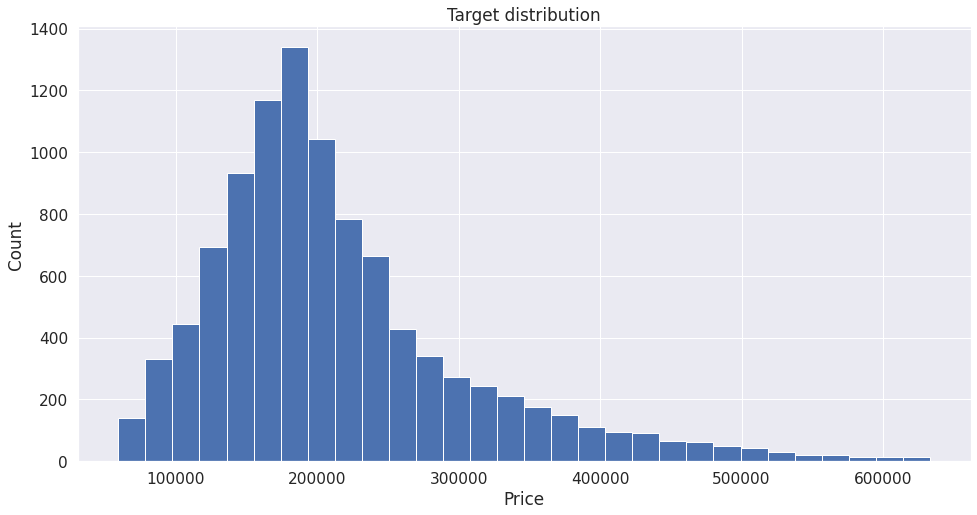

In [431]:
plt.figure(figsize = (16, 8))

df_train['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

In [432]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


**Категориальные переменные**

In [433]:
cat_colnames = df_train.select_dtypes(include='object').columns.tolist()
cat_colnames

[]

In [434]:
for cat_colname in cat_colnames[2:]:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

### Обработка выбросов

**Rooms**

In [435]:
df_train['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
6.0        1
19.0       1
Name: Rooms, dtype: int64

Rooms = 6: LifeSquare = 39
Rooms = 10: LifeSquare = 36, 38
Rooms = 19: LifeSquare = 22
Данные значения комнат - выбросы так как с такой жилой площадью это не обычно мало, и могут быть заменены на медиану
Rooms == 0 так же заменим на медианы так как площадь от олеблится от 48 до 87, другие значения похожи на выбросы

In [436]:
rooms_median = df_train['Rooms'].median()
rooms_median

2.0

In [437]:
df_train.loc[df_train['Rooms'] > 5, 'Rooms'] = rooms_median

In [438]:
df_train.loc[df_train['Rooms'] < 1, 'Rooms'] = rooms_median

In [439]:
df_train['Rooms'].value_counts()

2.0    3892
1.0    3705
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

**Square, LifeSquare, KitchenSquare**

In [440]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.888400,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,0.811071,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,1.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,5.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [441]:
df_train[df_train['Square']<df_train['LifeSquare']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
28,8054,23,1.0,42.530045,43.967758,1.0,3,9.0,2014,0.034656,B,B,0,168,0,NaN,0,0,B,95338.195312
44,10521,38,3.0,104.211395,106.340401,0.0,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.062500
52,2301,1,2.0,61.400055,65.224602,0.0,17,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,199215.453125
123,8753,25,3.0,85.952309,89.803749,1.0,4,3.0,2017,0.069753,B,B,53,13670,4,NaN,1,11,B,309688.593750
153,9870,62,1.0,51.831474,53.491302,1.0,5,1.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,131797.468750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9884,41,30,2.0,59.015896,59.439083,12.0,5,5.0,2016,0.000078,B,B,22,6398,141,1046.0,3,23,B,126281.140625
9889,12918,23,2.0,51.440464,53.134243,51.0,3,17.0,2017,0.005767,B,B,1,388,0,NaN,0,0,B,88150.015625
9895,2737,27,3.0,123.430069,125.806984,123.0,5,10.0,2015,0.017647,B,B,2,469,0,NaN,0,0,B,234194.843750
9902,14001,73,1.0,44.098766,44.267551,1.0,7,24.0,2014,0.042032,B,B,37,6856,84,1940.0,2,5,B,381937.406250


**Square**

Применяю квантиль 1 - 99 к общей площади, выбросы удаляем

In [442]:
df_train = df_train[df_train['Square'].isnull() |
                    (df_train['Square'] < df_train['Square'].quantile(.99)) &
                    (df_train['Square'] > df_train['Square'].quantile(.01))]


**LifeSquare**

Подход к жилой площади:
среднее отношение жилой площади к общей - 0.6, 
Установим границы 0.8 - верхняя, 0.4 нижняя, все что выше или ниже корректируем, чтобы отношение было 0.6

Заполняем ячейки NA

In [443]:
df_train['LifeSquare'] = df_train['LifeSquare'].fillna(df_train['Square'] * 0.65)

Меняем значения выбросов

In [444]:
df_train.loc[(df_train['LifeSquare'] / df_train['Square']) > 0.85, 'LifeSquare'] = df_train['Square'] * 0.65

In [445]:
df_train.loc[(df_train['LifeSquare'] / df_train['Square']) < 0.45, 'LifeSquare'] = df_train['Square'] * 0.65

In [446]:
df_train['LifeSquare'].describe()

count    9800.000000
mean       34.853489
std        11.455952
min        15.168644
25%        25.891666
50%        32.740448
75%        42.882481
max        88.492653
Name: LifeSquare, dtype: float64

In [447]:
lifesquare_mean = df_train['LifeSquare'].mean()
lifesquare_median = df_train['LifeSquare'].median()
lifesquare_mode = df_train['LifeSquare'].mode()[0]
print(lifesquare_mean, lifesquare_median, lifesquare_mode)

34.85348892211914 32.740447998046875 32.901546


**KitchenSquare**

Подход к площади кухни кухня относится к нежилой площади, и примем что она занимает около половины нежилой зоны, определим допуски:
 - верхний - 0.6 (кухня занимает очень большую долю нежилой площади, на остальное не хватает места)
 - нижний - 0.2 (кухня не пропорционально доступной площади - очень маленькая)
 
 Все что вышло за этот допуск заменим , чтобы отношение было 0.4

In [448]:
df_train.loc[(df_train['KitchenSquare'] / (df_train['Square'] - df_train['LifeSquare'])) > 0.6]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
48,7596,23,1.0,47.080101,30.602064,12.0,3,9.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,96029.164062
53,6455,44,1.0,31.893484,20.946671,7.0,3,14.0,1973,0.175055,B,B,36,10055,3,NaN,1,0,B,182946.359375
58,1982,28,1.0,38.007935,23.281713,9.0,1,12.0,1970,0.118537,B,B,30,6207,1,1183.0,1,0,B,147636.765625
116,14571,78,1.0,44.570412,28.970766,10.0,18,24.0,2011,0.092291,B,B,21,4346,2,165.0,1,2,B,212821.671875
227,16395,2,3.0,79.722244,44.731220,72.0,12,16.0,1987,0.130618,B,B,39,10418,9,900.0,1,9,B,370148.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9823,1921,62,1.0,49.831490,32.390469,11.0,10,17.0,2013,0.072158,B,B,2,629,1,NaN,0,0,A,69578.117188
9860,15304,124,1.0,45.220100,29.393064,13.0,12,12.0,1974,0.122090,B,B,29,6566,7,1894.0,4,0,B,180351.781250
9864,8807,38,1.0,46.905048,30.488281,10.0,8,17.0,2019,0.060753,B,B,15,2787,2,520.0,0,7,B,256650.656250
9889,12918,23,2.0,51.440464,33.436302,51.0,3,17.0,2017,0.005767,B,B,1,388,0,NaN,0,0,B,88150.015625


In [449]:
df_train.loc[(df_train['KitchenSquare'] / (df_train['Square'] - df_train['LifeSquare'])) > 0.6, 'KitchenSquare'] = (df_train['Square'] - df_train['LifeSquare']) * 0.4

In [450]:
df_train.loc[(df_train['KitchenSquare'] / (df_train['Square'] - df_train['LifeSquare'])) < 0.2]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
7,11993,74,2.0,80.312927,52.203400,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156250
8,5172,1,2.0,64.511436,41.932430,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.796875
12,6452,13,2.0,54.522804,31.759752,1.0,8,12.0,1999,0.090799,B,B,74,19083,2,NaN,5,15,B,229220.375000
14,10953,27,1.0,53.769096,34.949913,1.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27,1.0,38.968338,25.329418,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.570312
9986,2996,1,2.0,64.994247,42.246258,1.0,9,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200332.515625
9987,15623,23,2.0,55.620090,36.153057,0.0,2,4.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,115797.554688
9994,4158,23,2.0,64.864197,42.161728,1.0,17,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,171323.515625


In [451]:
df_train[df_train['KitchenSquare'] < 2]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.906250
7,11993,74,2.0,80.312927,52.203400,0.0,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.156250
8,5172,1,2.0,64.511436,41.932430,1.0,9,17.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,229102.796875
12,6452,13,2.0,54.522804,31.759752,1.0,8,12.0,1999,0.090799,B,B,74,19083,2,NaN,5,15,B,229220.375000
14,10953,27,1.0,53.769096,34.949913,1.0,5,4.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,140647.562500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9985,16159,27,1.0,38.968338,25.329418,1.0,10,1.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,95529.570312
9986,2996,1,2.0,64.994247,42.246258,1.0,9,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,200332.515625
9987,15623,23,2.0,55.620090,36.153057,0.0,2,4.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,115797.554688
9994,4158,23,2.0,64.864197,42.161728,1.0,17,17.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,171323.515625


In [452]:
df_train.loc[(df_train['KitchenSquare'] / (df_train['Square'] - df_train['LifeSquare'])) < 0.2, 'KitchenSquare'] = (df_train['Square'] - df_train['LifeSquare']) * 0.4

In [453]:
df_train['KitchenSquare'].describe()

count    9800.000000
mean        7.896811
std         2.358629
min         2.193436
25%         6.000000
50%         8.000000
75%         9.241365
max        27.000000
Name: KitchenSquare, dtype: float64

In [454]:
df_train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,9800.000000,9800.000000,9800.000000,9800.000000,9800.000000,9800.000000,9.800000e+03,9800.000000,9800.000000,9800.000000,9800.000000,5106.000000,9800.000000,9800.000000,9800.000000
mean,1.884184,55.669083,34.853489,7.896811,8.551531,12.679796,4.031038e+03,0.119049,24.767551,5370.852551,7.993061,1136.263062,1.316531,4.238571,213698.203125
std,0.798971,16.911280,11.455952,2.358629,5.216939,6.717761,2.025358e+05,0.119219,17.520098,4005.838231,23.718206,1018.821289,1.490184,4.797908,91040.484375
min,1.000000,29.719934,15.168644,2.193436,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,1.000000,41.891181,25.891666,6.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,154530.269531
50%,2.000000,52.513309,32.740448,8.000000,7.000000,14.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192342.953125
75%,2.000000,65.687443,42.882481,9.241365,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.000000,6.000000,248766.582031
max,5.000000,117.855972,88.492653,27.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


In [455]:
df_train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9800 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             9800 non-null   category
 1   DistrictId     9800 non-null   category
 2   Rooms          9800 non-null   float32 
 3   Square         9800 non-null   float32 
 4   LifeSquare     9800 non-null   float32 
 5   KitchenSquare  9800 non-null   float32 
 6   Floor          9800 non-null   int8    
 7   HouseFloor     9800 non-null   float32 
 8   HouseYear      9800 non-null   int32   
 9   Ecology_1      9800 non-null   float32 
 10  Ecology_2      9800 non-null   category
 11  Ecology_3      9800 non-null   category
 12  Social_1       9800 non-null   int8    
 13  Social_2       9800 non-null   int16   
 14  Social_3       9800 non-null   int16   
 15  Healthcare_1   5106 non-null   float32 
 16  Helthcare_2    9800 non-null   int8    
 17  Shops_1        9800 non-null   in

**HouseFloor, Floor**

In [456]:
df_train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  48.,  99., 117.],
      dtype=float32)

In [457]:
df_train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [458]:
df_train[df_train['HouseFloor'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
7,11993,74,2.0,80.312927,52.203400,11.243812,14,0.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B,221244.15625
26,4378,27,3.0,106.958870,69.523262,14.974243,17,0.0,2018,0.072158,B,B,2,629,1,NaN,0,0,A,337299.87500
39,9371,23,2.0,60.503250,39.327110,8.470456,16,0.0,1977,0.034656,B,B,0,168,0,NaN,0,0,B,229778.06250
44,10521,38,3.0,104.211395,67.737404,14.589597,20,0.0,2017,0.060753,B,B,15,2787,2,520.0,0,7,B,435462.06250
65,11398,62,1.0,41.194187,26.776220,5.767187,6,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,114063.09375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9707,12302,30,1.0,46.072914,29.947393,6.450208,4,0.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B,161403.09375
9769,9384,59,3.0,98.607330,64.094765,13.805026,14,0.0,1977,0.019509,B,B,37,7687,11,176.0,5,5,B,492700.25000
9878,11441,62,2.0,71.985336,46.790466,10.077949,5,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,158841.62500
9908,3171,62,1.0,35.873962,23.318075,5.022355,25,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,134379.12500


In [459]:
df_train.loc[df_train['HouseFloor'] == 0, 'HouseFloor'] = df_train['HouseFloor'].median()

In [460]:
np.random.seed(27)
floor_outliers = df_train[df_train['Floor'] > df_train['HouseFloor']].index
print(len(floor_outliers))

df_train.loc[floor_outliers, 'Floor'] = df_train.loc[floor_outliers, 'HouseFloor'].apply(
    lambda x: random.randint(1, x)
)

1546


**House year**

In [461]:
df_train['HouseYear'].value_counts().sort_index()

1910          1
1912          1
1914          1
1916          1
1917          3
           ... 
2018        171
2019         75
2020         19
4968          1
20052011      1
Name: HouseYear, Length: 97, dtype: int64

In [462]:
df_train.loc[df_train['HouseYear'] > 2020, 'HouseYear'] = df_train['HouseYear'].median()

In [463]:
len(df_train) - df_train.count()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare          0
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4694
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [464]:
df_train['Healthcare_1'].head()

0       NaN
1     240.0
2     229.0
3    1084.0
4    2078.0
Name: Healthcare_1, dtype: float32

In [465]:
df_train.loc[df_train['Healthcare_1'].isnull(), 'Healthcare_1'] = df_train['Healthcare_1'].median()

In [466]:
len(df_train) - df_train.count()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
dtype: int64

### Анализ признаков

In [467]:
df_train_num_features = df_train.select_dtypes(include=['float64', 'float32', 'float16', 'int16', 'int8'])
df_train_num_features.drop('Price', axis=1, inplace=True)

In [468]:
df_train_num_features

,Rooms,Square,LifeSquare,KitchenSquare,HouseFloor,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,2.0,47.981560,29.442751,6.000000,9.0,0.089040,33,7976,5,900.0,0,11
1,3.0,65.683640,40.049541,8.000000,9.0,0.000070,46,10309,1,240.0,1,16
2,2.0,44.947952,29.197611,6.300137,12.0,0.049637,34,7759,0,229.0,1,3
3,2.0,53.352982,34.679436,9.000000,17.0,0.437885,23,5735,3,1084.0,0,5
4,1.0,39.649193,23.776169,7.000000,12.0,0.012339,35,5776,1,2078.0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,50.401787,30.476204,5.000000,5.0,0.135650,46,7960,6,350.0,3,11
9996,1.0,41.521545,20.539215,9.000000,13.0,0.000000,30,5562,0,900.0,0,5
9997,1.0,47.939007,31.160353,6.711462,16.0,0.072158,2,629,1,900.0,0,0
9998,2.0,43.602562,33.840149,3.904965,5.0,0.307467,30,5048,9,325.0,2,5


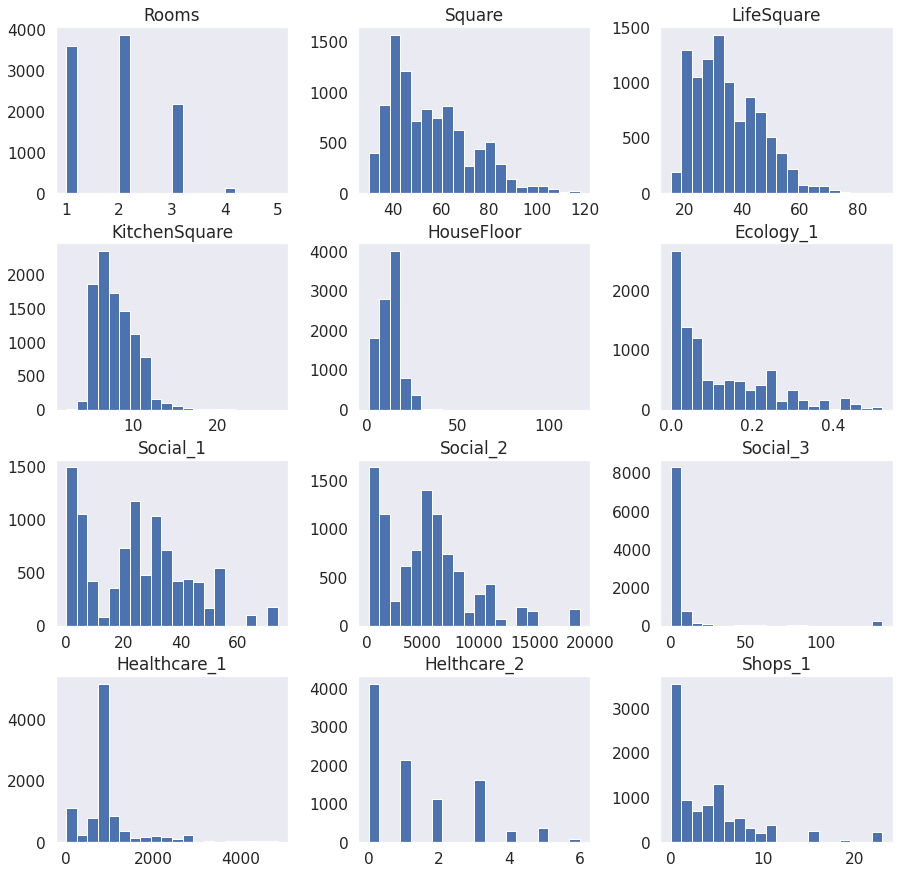

In [469]:
df_train_num_features.hist(figsize=(15,15), bins=20, grid=False);

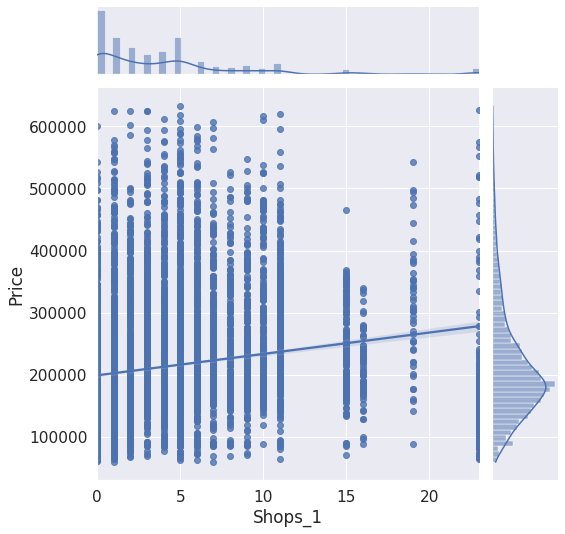

In [470]:
grid = sns.jointplot(df_train['Shops_1'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

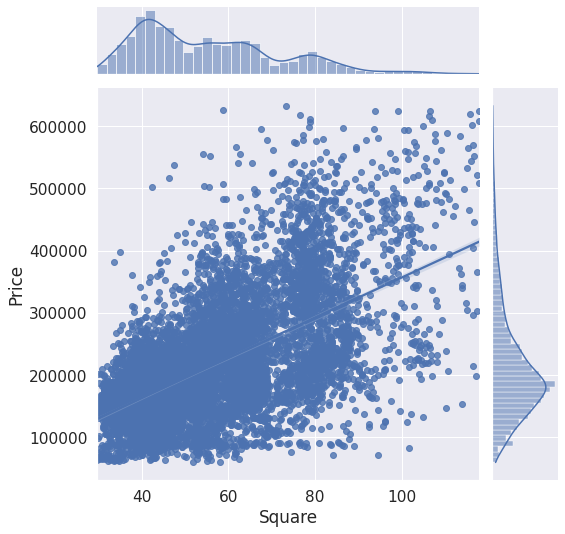

In [471]:
grid = sns.jointplot(df_train['Square'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

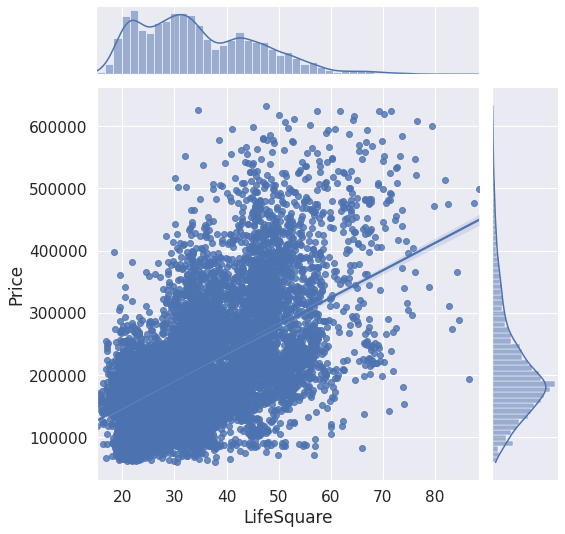

In [472]:
grid = sns.jointplot(df_train['LifeSquare'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

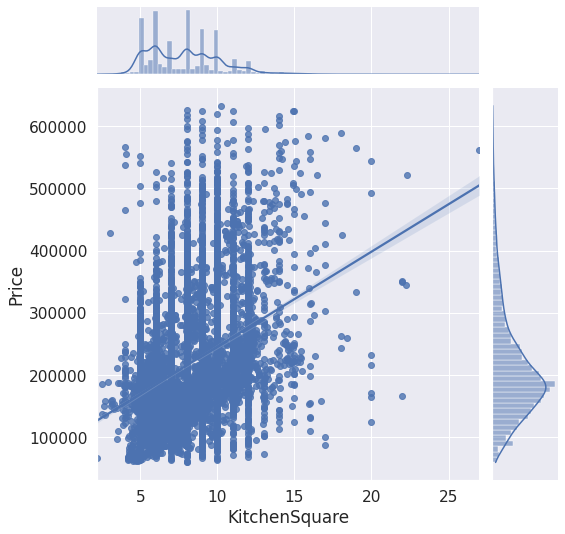

In [473]:
grid = sns.jointplot(df_train['KitchenSquare'], df_train['Price'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

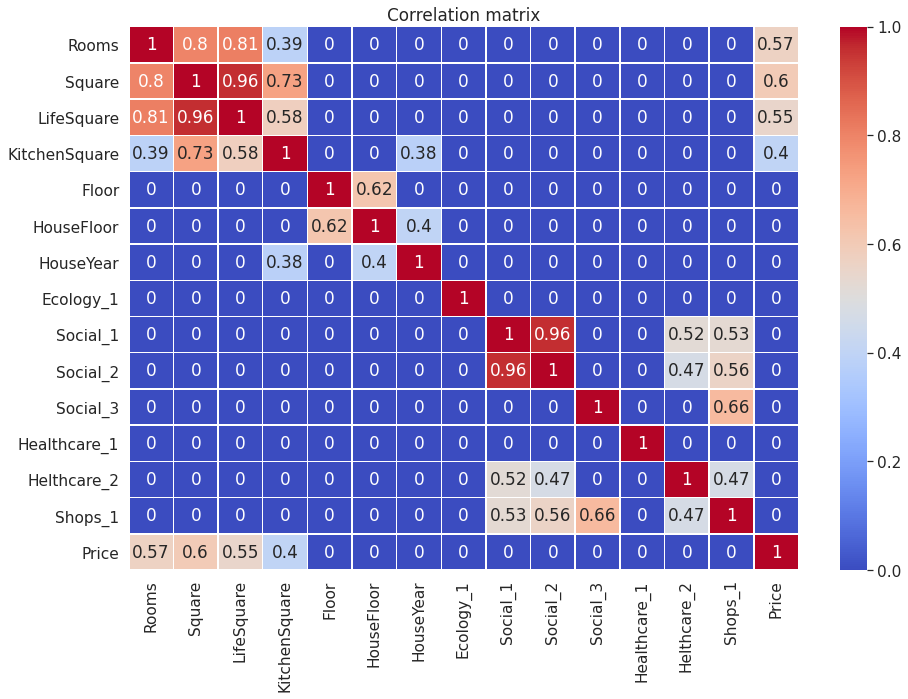

In [474]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Построение новых признаков

**Dummies**

In [475]:
df_train['Shops_2']

0       B
1       B
2       B
3       B
4       B
       ..
9995    B
9996    A
9997    A
9998    B
9999    B
Name: Shops_2, Length: 9800, dtype: category
Categories (2, object): ['A', 'B']

In [476]:
def dummies_a_b(df, col_name, new_col_name):
    df[new_col_name] = df[col_name].replace({'A':0, 'B':1})
    return df[new_col_name]

In [477]:
df_train['Ecology_2_bin'] = dummies_a_b(df_train, 'Ecology_2', 'Ecology_2_bin')
df_train['Ecology_3_bin'] = dummies_a_b(df_train, 'Ecology_3', 'Ecology_3_bin')
df_train['Shops_2_bin'] = dummies_a_b(df_train, 'Shops_2', 'Shops_2_bin')

In [478]:
df_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin
0,14038,35,2.0,47.981560,29.442751,6.000000,7,9.0,1969,0.089040,...,7976,5,900.0,0,11,B,184966.937500,1,1,1
1,15053,41,3.0,65.683640,40.049541,8.000000,7,9.0,1978,0.000070,...,10309,1,240.0,1,16,B,300009.437500,1,1,1
2,4765,53,2.0,44.947952,29.197611,6.300137,8,12.0,1968,0.049637,...,7759,0,229.0,1,3,B,220925.906250,1,1,1
3,5809,58,2.0,53.352982,34.679436,9.000000,8,17.0,1977,0.437885,...,5735,3,1084.0,0,5,B,175616.234375,1,1,1
4,10783,99,1.0,39.649193,23.776169,7.000000,11,12.0,1976,0.012339,...,5776,1,2078.0,2,4,B,150226.531250,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,77,32,2.0,50.401787,30.476204,5.000000,4,5.0,1968,0.135650,...,7960,6,350.0,3,11,B,196684.312500,1,1,1
9996,6159,18,1.0,41.521545,20.539215,9.000000,13,13.0,2000,0.000000,...,5562,0,900.0,0,5,A,189050.296875,1,1,0
9997,5123,27,1.0,47.939007,31.160353,6.711462,12,16.0,2015,0.072158,...,629,1,900.0,0,0,A,159143.812500,1,1,0
9998,5400,75,2.0,43.602562,33.840149,3.904965,1,5.0,1961,0.307467,...,5048,9,325.0,2,5,B,181595.343750,1,0,1


**DistrictSize, IsDistrictLarge**

In [479]:
def dist_size(df):
    district_size = df['DistrictId'].value_counts(normalize=True).reset_index()\
               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
    df = df.merge(district_size, on='DistrictId', how='left')
    return df, district_size

In [480]:
district_size = dist_size(df_train)[1]
district_size.head()

,DistrictId,DistrictSize
0,27,0.084490
1,1,0.066020
2,23,0.055000
3,6,0.052041
4,9,0.029796


In [481]:
df_train = dist_size(df_train)[0]#df_train.merge(district_size, on='DistrictId', how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981560,29.442751,6.000000,7,9.0,1969,0.089040,...,5,900.0,0,11,B,184966.937500,1,1,1,0.002245
1,15053,41,3.0,65.683640,40.049541,8.000000,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.437500,1,1,1,0.008776
2,4765,53,2.0,44.947952,29.197611,6.300137,8,12.0,1968,0.049637,...,0,229.0,1,3,B,220925.906250,1,1,1,0.017653
3,5809,58,2.0,53.352982,34.679436,9.000000,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.234375,1,1,1,0.018163
4,10783,99,1.0,39.649193,23.776169,7.000000,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531250,1,1,1,0.009694


In [482]:
(df_train['DistrictSize'] > 0.01).value_counts()

True     4976
False    4824
Name: DistrictSize, dtype: int64

In [483]:
def islarge(df):
    df['IsDistrictLarge'] = (df['DistrictSize'] > 0.01).astype(int)
    return df['IsDistrictLarge']

In [484]:
df_train['IsDistrictLarge'] = islarge(df_train)

df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,14038,35,2.0,47.981560,29.442751,6.000000,7,9.0,1969,0.089040,...,900.0,0,11,B,184966.937500,1,1,1,0.002245,0
1,15053,41,3.0,65.683640,40.049541,8.000000,7,9.0,1978,0.000070,...,240.0,1,16,B,300009.437500,1,1,1,0.008776,0
2,4765,53,2.0,44.947952,29.197611,6.300137,8,12.0,1968,0.049637,...,229.0,1,3,B,220925.906250,1,1,1,0.017653,1
3,5809,58,2.0,53.352982,34.679436,9.000000,8,17.0,1977,0.437885,...,1084.0,0,5,B,175616.234375,1,1,1,0.018163,1
4,10783,99,1.0,39.649193,23.776169,7.000000,11,12.0,1976,0.012339,...,2078.0,2,4,B,150226.531250,1,1,1,0.009694,0


In [485]:
df_train['DistrictSize'].describe()

count    9800.000000
mean        0.024198
std         0.026776
min         0.000102
25%         0.005612
50%         0.010510
75%         0.052041
max         0.084490
Name: DistrictSize, dtype: float64

In [486]:
df_train.groupby(['DistrictSize'])['Price'].mean()

DistrictSize
0.000102    337755.468750
0.000204    348211.687500
0.000306    308184.218750
0.000408    317094.625000
0.000510    293174.937500
                ...      
0.029796    190402.343750
0.052041    166183.078125
0.055000    127269.367188
0.066020    186777.078125
0.084490    155263.875000
Name: Price, Length: 85, dtype: float32

In [487]:
def med_price_by_district_size_sq(df):
        med_price_by_district_size = df.groupby(['DistrictSize', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict_size'})
        df = df.merge(med_price_by_district_size, on=['DistrictSize', 'Rooms'], how='left')
        return med_price_by_district_size, df


In [488]:
med_price_by_district_size = med_price_by_district_size_sq(df_train)[0]

med_price_by_district_size.head()

,DistrictSize,Rooms,MedPriceByDistrict_size
0,0.000102,1.0,180275.18750
1,0.000102,2.0,336584.12500
2,0.000102,3.0,424019.18750
3,0.000204,1.0,253077.21875
4,0.000204,2.0,423580.46875


In [489]:
df_train = med_price_by_district_size_sq(df_train)[1] #df_train.merge(med_price_by_district_size, on=['DistrictSize', 'Square'], how='left')
df_train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict_size
0,14038,35,2.0,47.981560,29.442751,6.000000,7,9.0,1969,0.089040,...,0,11,B,184966.937500,1,1,1,0.002245,0,207786.125000
1,15053,41,3.0,65.683640,40.049541,8.000000,7,9.0,1978,0.000070,...,1,16,B,300009.437500,1,1,1,0.008776,0,300009.437500
2,4765,53,2.0,44.947952,29.197611,6.300137,8,12.0,1968,0.049637,...,1,3,B,220925.906250,1,1,1,0.017653,1,263206.218750
3,5809,58,2.0,53.352982,34.679436,9.000000,8,17.0,1977,0.437885,...,0,5,B,175616.234375,1,1,1,0.018163,1,166809.671875
4,10783,99,1.0,39.649193,23.776169,7.000000,11,12.0,1976,0.012339,...,2,4,B,150226.531250,1,1,1,0.009694,0,170349.421875


In [490]:
def roomsvc(df):
    df["Rooms_vc"] = df["Rooms"].map(df["Rooms"].value_counts().to_dict())
    return df["Rooms_vc"]

In [491]:
df_train["Rooms_vc"] = roomsvc(df_train)
df_train["Rooms_vc"]

0       3880
1       2179
2       3880
3       3880
4       3602
        ... 
9795    3880
9796    3602
9797    3602
9798    3880
9799    3602
Name: Rooms_vc, Length: 9800, dtype: int64

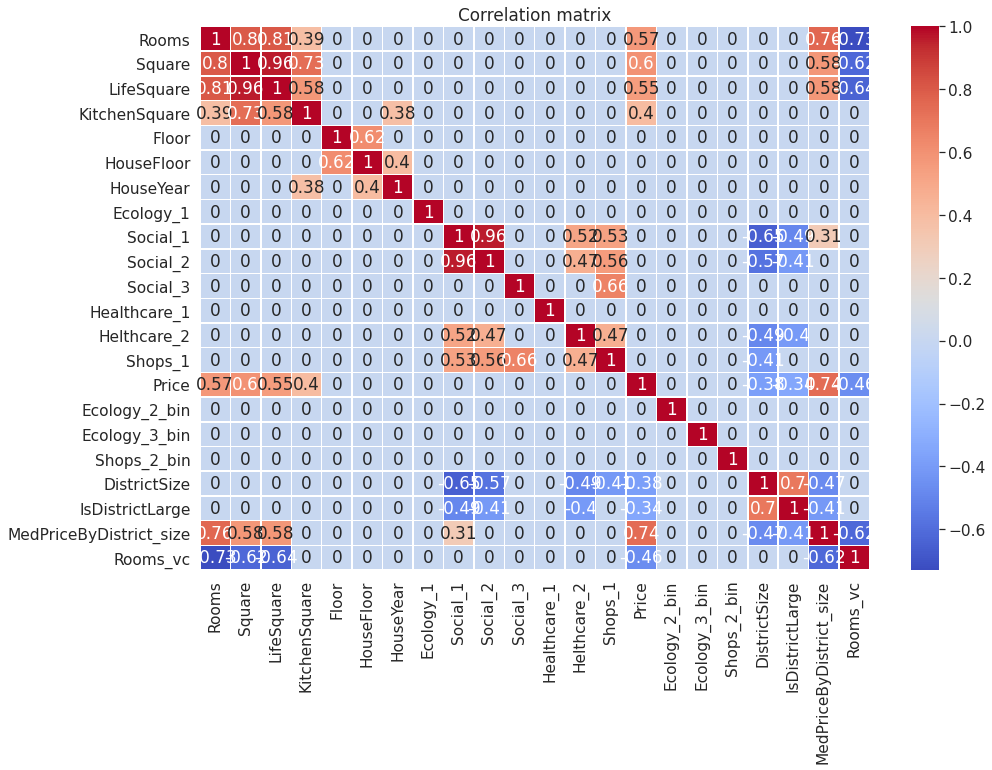

In [492]:
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков

In [493]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 500000], [0, 500000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

In [494]:
df_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict_size',
 'Rooms_vc']

In [495]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 'Ecology_1',  'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Ecology_2_bin', 'Ecology_3_bin',  'Shops_2_bin', 'DistrictSize', 'Rooms_vc', 'MedPriceByDistrict_size']
target_name = 'Price'

### Разбиение на train и test

In [496]:
X = df_train[feature_names]
y = df_train[target_name]

In [497]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=21
)

### Построение модели

R2:	0.814
RMSE:	38533.055
MSE:	1484796358.564


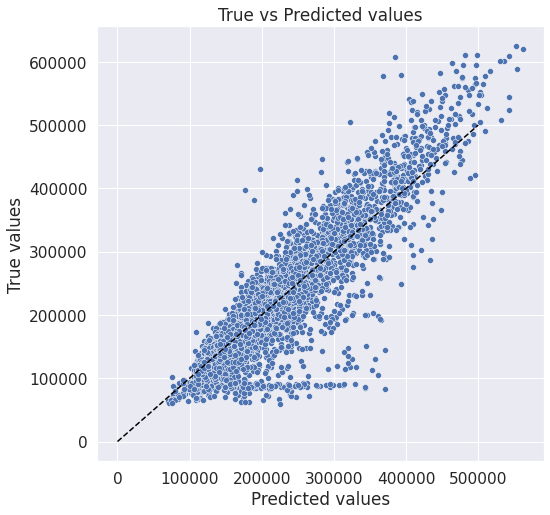

In [498]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=5,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=50)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.719
RMSE:	50060.607
MSE:	2506064369.633


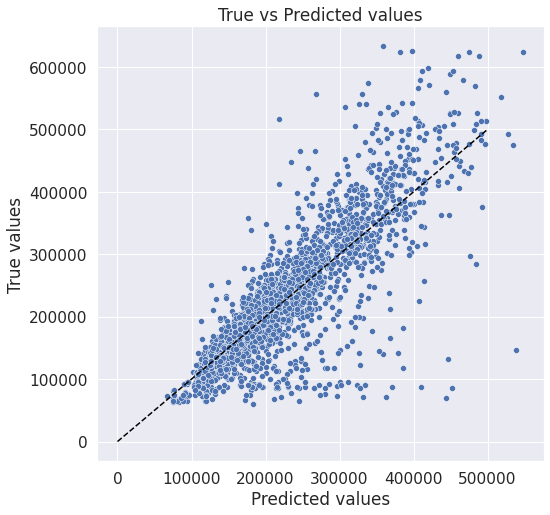

In [499]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

**Проверяем важность признаков**

In [500]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
19,MedPriceByDistrict_size,0.698880
1,Square,0.170934
17,DistrictSize,0.038437
10,Social_3,0.031385
3,KitchenSquare,0.018424
2,LifeSquare,0.012217
6,HouseYear,0.005876
9,Social_2,0.005070
7,Ecology_1,0.004418
8,Social_1,0.004110


## Формирование файла с прогнозами

In [501]:
test_id = df_test["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = np.random.randint(0, 1e6, size=test_id.shape[0])
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv("./RDziov_predictions_.csv", index=False)

In [502]:
pred_df = pd.read_csv("./RDziov_predictions_.csv")
pred_df.head(n=2)

,Id,Price
0,725,791571
1,15856,380600


In [503]:
df_test.shape[0]

5000

In [504]:
df_test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


 **Переношу признаки на тест**

In [505]:
df_test['Ecology_2_bin'] = dummies_a_b(df_test, 'Ecology_2', 'Ecology_2_bin')
df_test['Ecology_3_bin'] = dummies_a_b(df_test, 'Ecology_3', 'Ecology_3_bin')
df_test['Shops_2_bin'] = dummies_a_b(df_test, 'Shops_2', 'Shops_2_bin')

In [506]:
district_size = dist_size(df_test)[1]
district_size.head()

,DistrictId,DistrictSize
0,27,0.0782
1,1,0.0688
2,23,0.0528
3,6,0.0514
4,9,0.0264


In [507]:
df_test = dist_size(df_test)[0]
df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,2748,1,NaN,0,0,B,1,1,1,0.0182
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,...,1437,3,NaN,0,2,B,1,1,1,0.0122
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,7538,87,4702.0,5,5,B,1,1,1,0.0004
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,NaN,3,3,B,1,1,1,0.0098
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,629,1,NaN,0,0,A,1,1,0,0.0782


In [508]:
df_test['IsDistrictLarge'] = islarge(df_test)

df_test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,1,NaN,0,0,B,1,1,1,0.0182,1
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,...,3,NaN,0,2,B,1,1,1,0.0122,1
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,87,4702.0,5,5,B,1,1,1,0.0004,0
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,NaN,3,3,B,1,1,1,0.0098,0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,1,NaN,0,0,A,1,1,0,0.0782,1


In [509]:
df_test = df_test.merge(med_price_by_district_size, on=['DistrictSize', 'Rooms'], how='left')

Я сделал как в у вас в тетрадке, но в итоге в таблице NaN по этому столбцу, я не знаю как по другому сделать.

In [510]:
df_test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict_size
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,NaN,0,0,B,1,1,1,0.0182,1,NaN
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,...,NaN,0,2,B,1,1,1,0.0122,1,NaN
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,4702.0,5,5,B,1,1,1,0.0004,0,NaN
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,NaN,3,3,B,1,1,1,0.0098,0,NaN
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,NaN,0,0,A,1,1,0,0.0782,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,...,NaN,1,1,B,1,1,1,0.0090,0,NaN
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,...,NaN,0,1,B,1,1,1,0.0688,1,NaN
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,...,NaN,5,15,B,1,1,1,0.0072,0,NaN
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,...,NaN,0,0,A,1,1,0,0.0244,1,NaN


In [511]:
df_test["Rooms_vc"] = roomsvc(df_test)
df_test["Rooms_vc"]

0       2030
1       2030
2       1769
3       2030
4       1769
        ... 
4995    1099
4996    1769
4997    1099
4998    2030
4999    2030
Name: Rooms_vc, Length: 5000, dtype: int64

In [512]:
df_test

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict_size,Rooms_vc
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,0,0,B,1,1,1,0.0182,1,NaN,2030
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,...,0,2,B,1,1,1,0.0122,1,NaN,2030
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,5,5,B,1,1,1,0.0004,0,NaN,1769
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,3,3,B,1,1,1,0.0098,0,NaN,2030
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,0,0,A,1,1,0,0.0782,1,NaN,1769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,...,1,1,B,1,1,1,0.0090,0,NaN,1099
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,...,0,1,B,1,1,1,0.0688,1,NaN,1769
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,...,5,15,B,1,1,1,0.0072,0,NaN,1099
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,...,0,0,A,1,1,0,0.0244,1,NaN,2030
